# NBA Machine Learning Analysis - Players Fantasy Projection

This notebook focuses on analyzing NBA player performance data and projecting player Fantasy score using machine learning techniques. The workflow includes:

1. **Data Loading and Exploration, Cleaning, Prepocessing**:
    - Import and inspect datasets containing NBA box scores, game details, and player statistics.
    - Perform exploratory data analysis (EDA) to understand the structure and distribution of the data.
    - Handle missing values and clean the datasets to ensure consistency.
    - Merge and transform datasets as needed for analysis.

2. **Statistical Analysis**:
    - Analyze player performance metrics such as points, assists, rebounds, and shooting percentages.
    - Visualize data distributions and correlations between features.

3. **Player Performance Insights**:
    - Identify top-performing players based on key metrics.
    - Visualize trends and patterns in player performance.

4. **Machine Learning for Player Projections**:
    - Prepare data for machine learning by selecting relevant features.
    - Train and evaluate models to predict player statistics for future games.

5. **Visualization and Reporting**:
    - Use visualizations to communicate insights and findings effectively.
    - Document the workflow and results for reproducibility.

This notebook serves as a comprehensive guide for analyzing NBA data and leveraging machine learning to gain actionable insights into player performance.

## 1. **Data Loading, Exploration, Cleaning, Preprocessing**:

In [11]:
import pandas as pd
# Load datasets 
boxscore_df = pd.read_csv('databases/nba_boxscore_basic.csv', low_memory=False)
print(f"boxscore_df file Loaded: {boxscore_df.shape[0]} rows, {boxscore_df.shape[1]} columns")
players_df = pd.read_csv('databases/nba_players_df_2024-25.csv')
print(f"players_df file Loaded: {players_df.shape[0]} rows, {players_df.shape[1]} columns")
nba_teams_df = pd.read_csv('databases/nba_teams_df.csv')
print(f"nba_teams_df file Loaded: {nba_teams_df.shape[0]} rows, {nba_teams_df.shape[1]} columns")

boxscore_df file Loaded: 33361 rows, 45 columns
players_df file Loaded: 575 rows, 26 columns
nba_teams_df file Loaded: 30 rows, 7 columns


Show info of the dataframes

In [53]:
boxscore_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31997 entries, 0 to 31996
Data columns (total 45 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   gameId                   31997 non-null  int64  
 1   teamId                   31997 non-null  int64  
 2   teamCity                 31997 non-null  object 
 3   teamName                 31997 non-null  object 
 4   teamTricode              31997 non-null  object 
 5   teamSlug                 31997 non-null  object 
 6   personId                 31997 non-null  int64  
 7   firstName                31997 non-null  object 
 8   familyName               31997 non-null  object 
 9   nameI                    31997 non-null  object 
 10  playerSlug               31997 non-null  object 
 11  position                 12100 non-null  object 
 12  comment                  6090 non-null   object 
 13  jerseyNum                0 non-null      float64
 14  minutes               

In [54]:
players_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 575 entries, 0 to 574
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   PERSON_ID          575 non-null    int64  
 1   PLAYER_LAST_NAME   575 non-null    object 
 2   PLAYER_FIRST_NAME  575 non-null    object 
 3   PLAYER_SLUG        575 non-null    object 
 4   TEAM_ID            575 non-null    int64  
 5   TEAM_SLUG          534 non-null    object 
 6   IS_DEFUNCT         575 non-null    int64  
 7   TEAM_CITY          534 non-null    object 
 8   TEAM_NAME          534 non-null    object 
 9   TEAM_ABBREVIATION  534 non-null    object 
 10  JERSEY_NUMBER      530 non-null    float64
 11  POSITION           575 non-null    object 
 12  HEIGHT             575 non-null    object 
 13  WEIGHT             573 non-null    float64
 14  COLLEGE            575 non-null    object 
 15  COUNTRY            575 non-null    object 
 16  DRAFT_YEAR         429 non

In [123]:
nba_teams_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            30 non-null     int64 
 1   full_name     30 non-null     object
 2   abbreviation  30 non-null     object
 3   nickname      30 non-null     object
 4   city          30 non-null     object
 5   state         30 non-null     object
 6   year_founded  30 non-null     int64 
dtypes: int64(2), object(5)
memory usage: 1.8+ KB


###### Join dataframes
- First we will merge Players df with the Boxscore to get more player metadata info. 
- We dont need more Teams info for the moment

In [39]:
# Join with the Player df to get Player metadata
player_boxscore_df = boxscore_df.merge(
    players_df[['PERSON_ID', 'PLAYER_SLUG', 'HEIGHT', 'POSITION']],
    left_on='personId',
    right_on='PERSON_ID',
    how='left'
).drop('PERSON_ID', axis=1)

NaN Analysis 

In [13]:
player_boxscore_df.isna().sum().sort_values(ascending = False)

jerseyNum                  33361
playoffs_desc              32515
comment                    26931
position                   20761
minutes                     6430
POSITION                       8
PLAYER_SLUG                    8
HEIGHT                         8
visitor_team_tricode           0
is_regular_season              0
steals                         0
blocks                         0
turnovers                      0
foulsPersonal                  0
points                         0
plusMinusPoints                0
game_id                        0
is_playoffs                    0
visitor_team_id                0
reboundsTotal                  0
game_status_text               0
game_status                    0
game_date                      0
home_team_id                   0
home_team_tricode              0
assists                        0
gameId                         0
reboundsDefensive              0
playerSlug                     0
teamCity                       0
teamName  

### NaN Analysis and Decisions

1. **START_POSITION**:
    - Missing values: 19,296
    - Decision: This column might be important for analyzing player roles. Consider imputing missing values with "Bench" or "Unknown" if applicable. 

2. **COMMENT**:
    - Missing values: 25,158
    - Decision: This column seems to contain qualitative data. If not critical for analysis, it can be dropped. Otherwise, explore if missing values can be filled with a default comment like "No Comment".

3. **MIN (Minutes Played)**:
    - Missing values: 5,888
    - Decision: Missing values in this column could indicate players who did not participate in the game. Consider imputing with "0:00" or filtering out such rows if they are not relevant to the analysis.

4. **Players Metadata**:
    - Missing values: 5k+ 
    - Decision: These metrics are likely missing for players who are not present in the players_df database, so first investigate why 

Lets do more analysis before taking decision 

In [14]:
# Inspect player data missing values
player_boxscore_df[player_boxscore_df['PLAYER_SLUG'].isna()]['minutes'].unique()

array([nan], dtype=object)

We can see that the only missing players have not played a single minute during the season so this data will not be used, we can go ahead with the reste of the analysis 

##### EDA : Categorical Variables

In [63]:
def category_eda_charts(cat):

    # Import libraries
    from math import ceil
    import matplotlib.pyplot as plt
    # Create a row variable to define the number of rows in the chart
    rows = ceil(cat.shape[1] / 2)

    # Create a figure and axis object 
    f, ax = plt.subplots(nrows = rows, ncols = 2, figsize = (16, rows * 6))

    # Convert the axis object to a flat array
    # This is done to make it easier to loop through the axis object
    ax = ax.flat

    
    for each, variable in enumerate(cat):
        cat[variable].value_counts().plot.barh(ax = ax[each])
        ax[each].set_title(variable, fontsize = 12, fontweight = "bold")
        ax[each].tick_params(labelsize = 12)

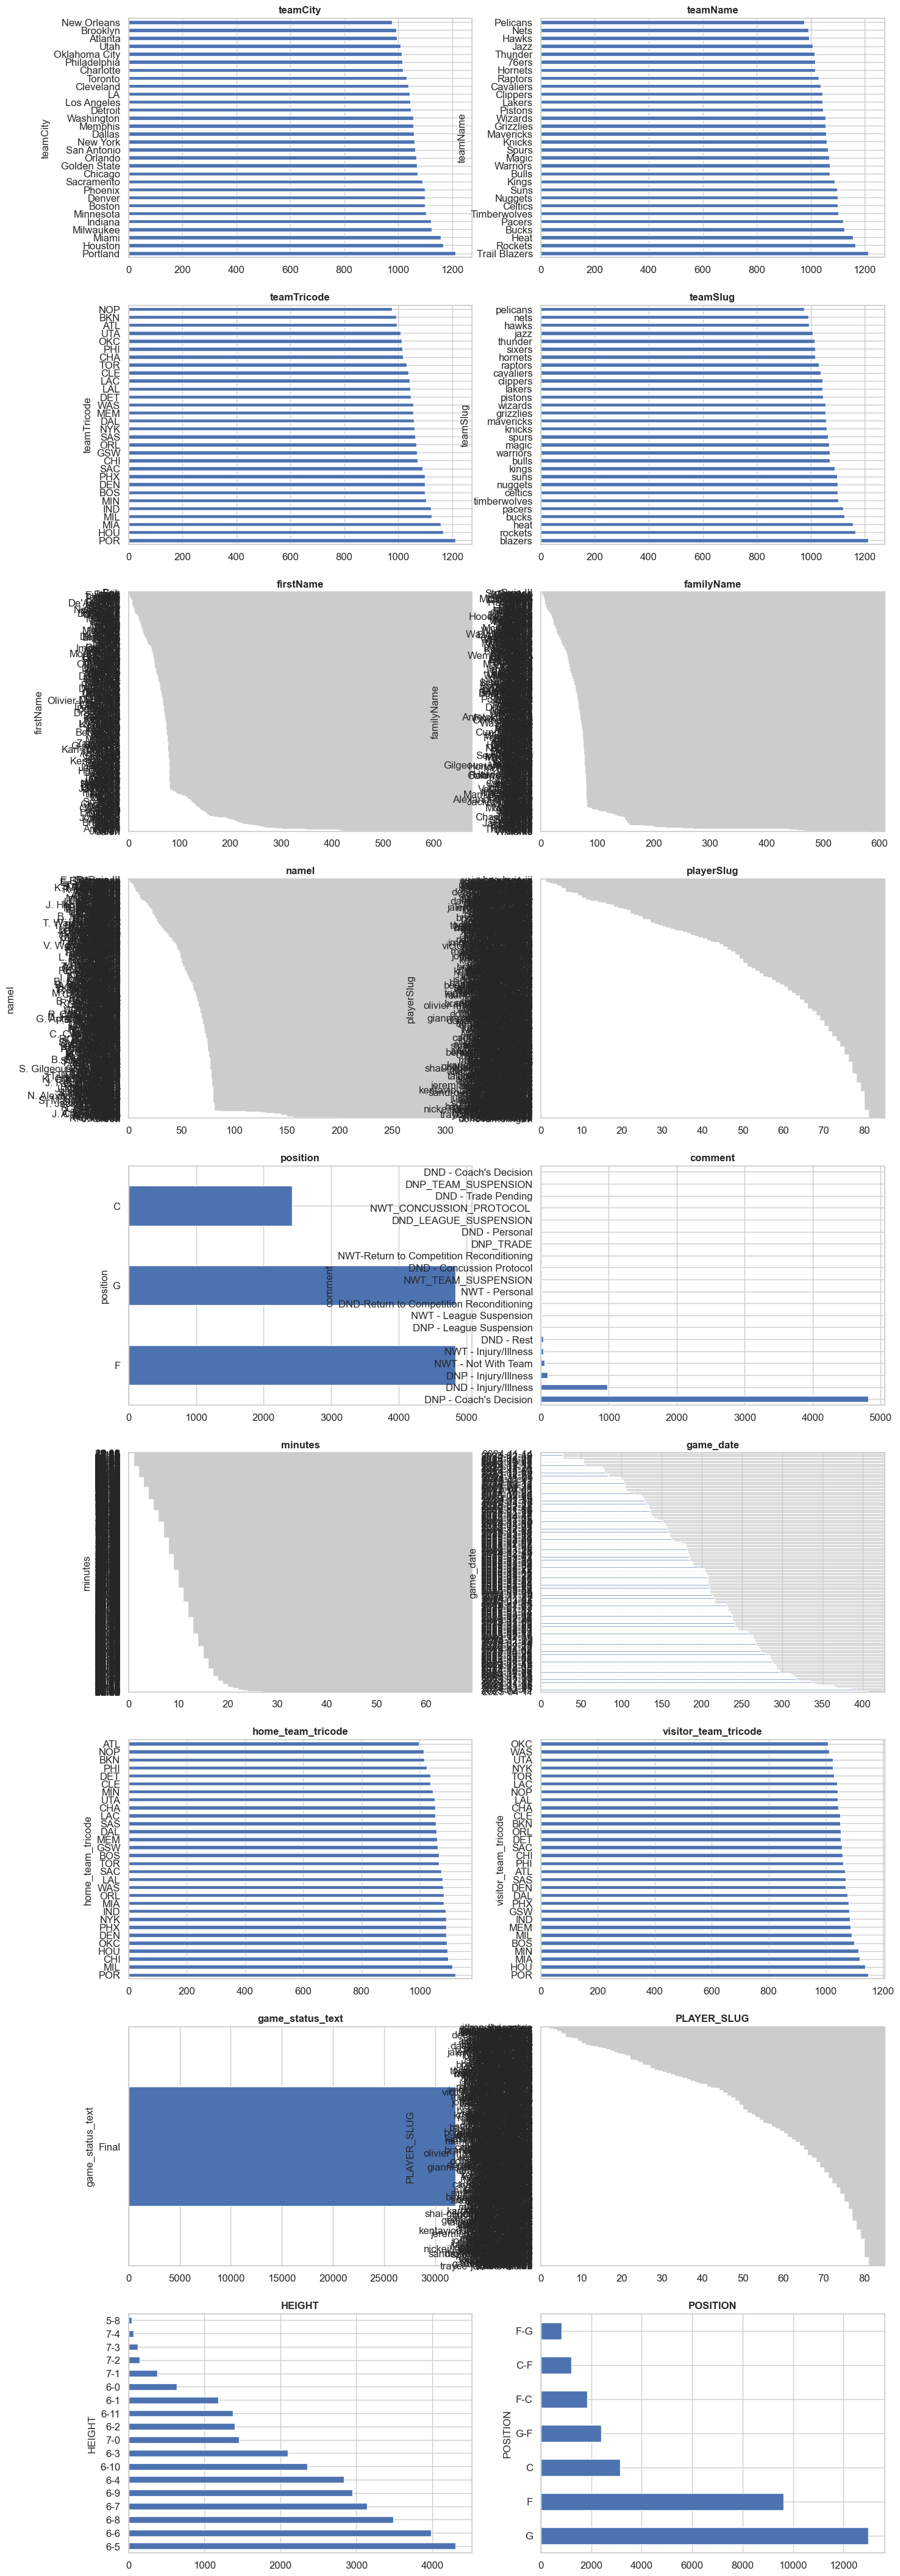

In [66]:
category_eda_charts(player_boxscore_df.select_dtypes('O'))

Conclusion : 
- "MIN" Column should be int 
- Comments column is only to justify that the player is not playing, so we can remove this column + remove rows where this column is not blank
- For Height column, should be used for deep ML model but for the moment we will keep it simple so we can remove this feature
- 2 columns Positions, one from the boxscore and one from the playerindex df.For simplicity we will keep the first position column. 
- If Start Position is not C/G/F then put "Bench"
- We will join data with the player_df with "PLAYER_ID" column so no need for additional columns like "PLAYER_NAME" and "NICKNAME", we can delete them.
- We can modify GAME_DATE column from string to datetime format
- Add a Season column to potenital future time decay

In [23]:
# First create a copy of the original dataframe to avoid reload data 
boxscore_df_transformed = player_boxscore_df.copy()
# Convert MIN column to numeric
# Extract minutes and seconds, then combine them into decimal format
boxscore_df_transformed['minutes'] = boxscore_df_transformed['minutes'].apply(lambda x: str(int(str(x).split(':')[0].split('.')[0])) + '.' + str(x).split(':')[1] if pd.notnull(x) else x).astype(float)

# Remove rows where COMMENT column is not null and MIN is  null
boxscore_df_transformed = boxscore_df_transformed[boxscore_df_transformed['comment'].isnull() | boxscore_df_transformed['minutes'].notnull()]

# Put "bench" to rows where "START POSITION" is null 
boxscore_df_transformed['position'] = boxscore_df_transformed['position'].fillna('BENCH')

# Convert GAME_DATE column to date format 
boxscore_df_transformed['game_date'] = pd.to_datetime(boxscore_df_transformed['game_date'], format= '%Y-%m-%d', errors='coerce')

# Remove unnecessary columns 
boxscore_df_transformed = boxscore_df_transformed.drop(columns=['firstName', 'familyName','nameI','playerSlug', 'comment'])

# Add a new column Season based on the game_id 
boxscore_df_transformed['Season'] = boxscore_df_transformed['game_id'].astype(str).str[1:3].astype(int) + 2000

In [92]:
boxscore_df_transformed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25907 entries, 0 to 31993
Data columns (total 44 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   gameId                   25907 non-null  int64         
 1   teamId                   25907 non-null  int64         
 2   teamCity                 25907 non-null  object        
 3   teamName                 25907 non-null  object        
 4   teamTricode              25907 non-null  object        
 5   teamSlug                 25907 non-null  object        
 6   personId                 25907 non-null  int64         
 7   position                 25907 non-null  object        
 8   jerseyNum                0 non-null      float64       
 9   minutes                  25907 non-null  float64       
 10  fieldGoalsMade           25907 non-null  int64         
 11  fieldGoalsAttempted      25907 non-null  int64         
 12  fieldGoalsPercentage     25907 non-nu

##### EDA : Numerical Variables

In [68]:
def continuous_statistics(num):
    # Calculate basic descriptive statistics using .describe()
    # This includes: count, mean, std, min, 25%, 50%, 75%, max
    statistics = num.describe().T  # Transpose to get variables as rows

    # Add the median manually (even though .describe() includes 50%, this is for clarity or comparison)
    statistics['median'] = num.median()

    # Reorder the columns so that 'median' appears next to 'mean'
    # The original .describe() gives: count, mean, std, min, 25%, 50%, 75%, max
    # We're rearranging to: count, mean, median, std, min, 25%, 50%, 75%, max
    statistics = statistics.iloc[:, [0, 1, 8, 2, 3, 4, 5, 6, 7]]

    # Return the final DataFrame of statistics
    return statistics

In [79]:
# Set display options for better readability
pd.set_option('display.float_format', '{:.2f}'.format)
# Execute the function 
continuous_statistics(boxscore_df.select_dtypes('number'))

count          mean        median       std  \
gameId                  31997.00   22400608.48   22400609.00    352.39   
teamId                  31997.00 1610612751.48 1610612751.00      8.58   
personId                31997.00    1402385.15    1630183.00 526632.57   
jerseyNum                   0.00           NaN           NaN       NaN   
fieldGoalsMade          31997.00          3.15          2.00      3.29   
fieldGoalsAttempted     31997.00          6.75          6.00      6.33   
fieldGoalsPercentage    31997.00          0.35          0.38      0.28   
threePointersMade       31997.00          1.02          0.00      1.46   
threePointersAttempted  31997.00          2.84          2.00      3.15   
threePointersPercentage 31997.00          0.22          0.00      0.28   
freeThrowsMade          31997.00          1.28          0.00      2.12   
freeThrowsAttempted     31997.00          1.64          0.00      2.56   
freeThrowsPercentage    31997.00          0.34          0.00      0.42   
reboundsOffensive       31997.00          0.84          0.00      1.31   
reboundsDefensive       31997.00          2.49          2.00      2.72   
reboundsTotal           31997.00          3.34          3.00      3.51   
assists                 31997.00          2.01          1.00      2.55   
steals                  31997.00          0.62          0.00      0.94   
blocks                  31997.00          0.37          0.00      0.76   
turnovers               31997.00          1.02          1.00      1.37   
foulsPersonal           31997.00          1.41          1.00      1.46   
points                  31997.00          8.61          6.00      8.95   
plusMinusPoints         31997.00         -0.00          0.00     10.52   
game_id                 31997.00   22400608.48   22400609.00    352.39   
playoffs_desc               0.00           NaN           NaN       NaN   
home_team_id            31997.00 1610612751.54 1610612752.00      8.61   
visitor_team_id         31997.00 1610612751.42 1610612751.00      8.62   
game_status             31997.00          3.00          3.00      0.00   

                                  min           25%           50%  \
gameId                    22400001.00   22400304.00   22400609.00   
teamId                  1610612737.00 1610612744.00 1610612751.00   
personId                      2544.00    1628368.00    1630183.00   
jerseyNum                         NaN           NaN           NaN   
fieldGoalsMade                   0.00          0.00          2.00   
fieldGoalsAttempted              0.00          1.00          6.00   
fieldGoalsPercentage             0.00          0.00          0.38   
threePointersMade                0.00          0.00          0.00   
threePointersAttempted           0.00          0.00          2.00   
threePointersPercentage          0.00          0.00          0.00   
freeThrowsMade                   0.00          0.00          0.00   
freeThrowsAttempted              0.00          0.00          0.00   
freeThrowsPercentage             0.00          0.00          0.00   
reboundsOffensive                0.00          0.00          0.00   
reboundsDefensive                0.00          0.00          2.00   
reboundsTotal                    0.00          0.00          3.00   
assists                          0.00          0.00          1.00   
steals                           0.00          0.00          0.00   
blocks                           0.00          0.00          0.00   
turnovers                        0.00          0.00          1.00   
foulsPersonal                    0.00          0.00          1.00   
points                           0.00          0.00          6.00   
plusMinusPoints                -58.00         -5.00          0.00   
game_id                   22400001.00   22400304.00   22400609.00   
playoffs_desc                     NaN           NaN           NaN   
home_team_id            1610612737.00 1610612744.00 1610612752.00   
visitor_team_id  

Conclusion : 
- We can remove jerseyNumb column, not revelant and empty 
- We can add a column "Against" to have the Opponant team_id 
- We add a column "isHome" to flag home/away 
- As the Fantasy Score is a global Score from almost all the metrics, we can just calculate it and remove unnecessary data. 

In [24]:
# Add a column that will put the Opponent team 
boxscore_df_transformed['Opponent'] = boxscore_df_transformed.apply(
    lambda x: x['visitor_team_id'] if x['teamId'] == x['home_team_id'] 
    else x['home_team_id'], axis=1)

# Add a column to flag is the player is playing at home or away 
boxscore_df_transformed['isHome'] = boxscore_df_transformed.apply(
    lambda x: True if x['teamId'] == x['home_team_id'] else False, axis=1
)

# Calculate missed shots columns first
boxscore_df_transformed['fieldGoalsMissed'] = boxscore_df_transformed['fieldGoalsAttempted'] - boxscore_df_transformed['fieldGoalsMade']
boxscore_df_transformed['threePointersMissed'] = boxscore_df_transformed['threePointersAttempted'] - boxscore_df_transformed['threePointersMade']
boxscore_df_transformed['freeThrowsMissed'] = boxscore_df_transformed['freeThrowsAttempted'] - boxscore_df_transformed['freeThrowsMade']

#  Calculate Fantasy Points (FP) using the provided formula
boxscore_df_transformed['FP'] = (boxscore_df_transformed['points'] + 
                                boxscore_df_transformed['fieldGoalsMade'] +
                                boxscore_df_transformed['threePointersMade'] +
                                boxscore_df_transformed['freeThrowsMade'] +
                                boxscore_df_transformed['reboundsTotal'] +
                                boxscore_df_transformed['steals'] +
                                boxscore_df_transformed['blocks']) - \
                               (boxscore_df_transformed['fieldGoalsMissed'] + 
                                boxscore_df_transformed['threePointersMissed'] + 
                                boxscore_df_transformed['freeThrowsMissed'] + 
                                boxscore_df_transformed['turnovers'])

# Only keep relevant columns for the analysis
boxscore_df_transformed = boxscore_df_transformed[[
    'game_id',
    'game_date', 
    'teamTricode',
    'Opponent',
    'personId',
    'position',
    'minutes',
    'points',
    'fieldGoalsMade',
    'fieldGoalsMissed',
    'threePointersMade',
    'threePointersMissed',
    'freeThrowsMade',
    'freeThrowsMissed',
    'reboundsTotal',
    'steals',
    'blocks',
    'turnovers',
    'FP'
]]

In [25]:
boxscore_df_transformed.head()

game_id  game_date teamTricode    Opponent  personId position  minutes  \
0  22400455 2025-01-01         ORL  1610612765   1641783        F    22.42   
1  22400455 2025-01-01         ORL  1610612765   1628976        F    34.04   
2  22400455 2025-01-01         ORL  1610612765   1629048        C    22.39   
3  22400455 2025-01-01         ORL  1610612765    203484        G    34.23   
4  22400455 2025-01-01         ORL  1610612765   1630591        G    33.49   

   points  fieldGoalsMade  fieldGoalsMissed  threePointersMade  \
0       0               0                 6                  0   
1      15               7                 8                  0   
2       8               3                 5                  0   
3      21               8                 3                  4   
4      24               9                11                  3   

   threePointersMissed  freeThrowsMade  freeThrowsMissed  reboundsTotal  \
0                    1               0                 0              6   
1                    4               1                 1              8   
2                    0               2                 2              3   
3                    2               1                 0              2   
4                    6               3                 1              4   

   steals  blocks  turnovers  FP  
0       1       0          1  -1  
1       2       1          1  20  
2       1       0          2   8  
3       2       1          2  32  
4       3       2          2  28

### Cleaning & Preprocessing Data 

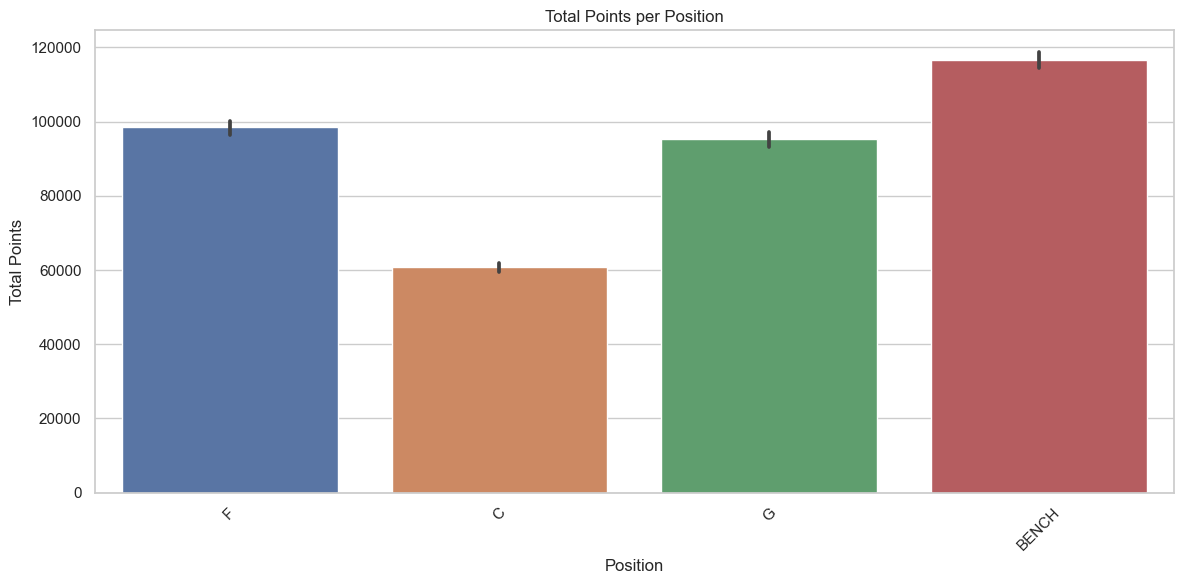

In [ ]:
# Points per position
#Import libraries	
import matplotlib.pyplot as plt
import seaborn as sns
# Set the style of seaborn
sns.set(style="whitegrid")
# Create a figure and axis object
plt.figure(figsize=(12, 6))
# Create a bar plot using seaborn
sns.barplot(x='position', y='FP', data=boxscore_df_transformed, estimator=sum)
plt.title('Total Points per Position')
plt.xlabel('Position')
plt.ylabel('Total Points')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

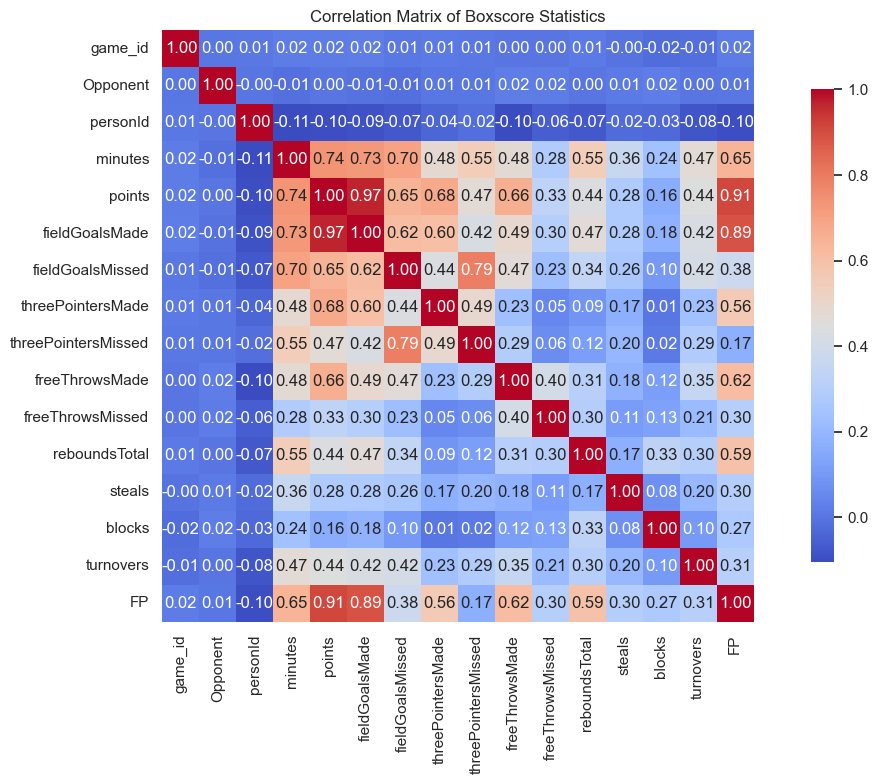

In [101]:
# Correlation Matrix 
import seaborn as sns
import matplotlib.pyplot as plt
# Select only numerical columns
numerical_columns = boxscore_df_transformed.select_dtypes(include=['float64', 'int64']).columns

# Set the size of the figure
plt.figure(figsize=(12, 8))
# Create a heatmap using seaborn
sns.heatmap(boxscore_df_transformed[numerical_columns].corr(), annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Correlation Matrix of Boxscore Statistics')
plt.tight_layout()
plt.show()

In [102]:
boxscore_df_transformed.columns

Index(['game_id', 'game_date', 'teamTricode', 'Opponent', 'personId',
       'position', 'minutes', 'points', 'fieldGoalsMade', 'fieldGoalsMissed',
       'threePointersMade', 'threePointersMissed', 'freeThrowsMade',
       'freeThrowsMissed', 'reboundsTotal', 'steals', 'blocks', 'turnovers',
       'FP'],
      dtype='object')

In [106]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

relationships = [
    ('position', 'FP'),
    ('points', 'FP'),
    ('fieldGoalsMissed', 'FP'),
    ('threePointersMissed', 'FP'),
    ('freeThrowsMissed', 'FP'),
    ('reboundsTotal', 'FP'),
    ('steals', 'FP'),
    ('blocks', 'FP'),
    ('turnovers', 'FP')
]

fig = make_subplots(rows=3, cols=3)

for idx, (x_col, y_col) in enumerate(relationships, start=1):
    row = (idx - 1) // 3 + 1
    col = (idx - 1) % 3 + 1
    fig.add_trace(go.Scatter(x=boxscore_df_transformed[x_col], y=boxscore_df_transformed[y_col], mode='markers' if idx != 3 else 'lines'), row=row, col=col)

    fig.update_xaxes(title_text=x_col, row=row, col=col)
    fig.update_yaxes(title_text=y_col, row=row, col=col)

fig.update_layout(
    title_text='Relationships between Different Columns',
    height=800,
    width=1000,
    template='plotly_dark'
)

fig.update_layout(showlegend=False)
fig.update_annotations(dict(text='', showarrow=False))

fig.show()

In [97]:
import plotly.graph_objects as go
# Create a scatter plot using Plotly
fig_points_minutes_scatter = go.Figure()

# Create a scatter plot for Total Fantasy Points vs. Minutes Played
fig_points_minutes_scatter.add_trace(go.Scatter(x=boxscore_df_transformed['minutes'], y=boxscore_df_transformed['FP'],
                                               mode='markers', marker_color='orangered', opacity=0.7))

# Add a trend line using linear regression
fig_points_minutes_scatter.update_layout(title='Fantasy Points vs. Minutes Played',
                                         xaxis_title='Minutes Played',
                                         yaxis_title='FP',
                                         template='plotly_dark')

fig_points_minutes_scatter.show()

In [90]:
import plotly.express as px
px.histogram(boxscore_df_transformed, x='teamTricode', color_discrete_sequence=px.colors.qualitative.Vivid, 
             title='Players teams counts', template='plotly_dark')

#### Position and Correlation Analysis

1. **Position Analysis**:
    - **Bench Players**: Have lowest Fantasy Points, suggesting they get limited playing time and opportunities
    - **Centers and Guards**: Generate highest total Fantasy Points, indicating they tend to have more opportunities for statistical contributions
    - **Forwards**: Show moderate Fantasy Point production, falling between Bench and C/G positions

2. **Correlation Insights**:
    - **Minutes-FP Correlation**: Strong positive correlation (~0.8) between minutes played and Fantasy Points, confirming that playing time is a key driver of fantasy production
    - **Points-FP Relationship**: Very strong positive correlation (~0.9) with Fantasy Points, as scoring is a major component
    - **Negative Impact Stats**: Missed shots and turnovers show negative correlations with FP, as expected per scoring rules
    - **Defensive Stats**: Steals and blocks show moderate positive correlations (~0.4), contributing to overall fantasy value

3. **Team Distribution**:
    - Even distribution of players across teams, indicating balanced roster sizes
    - No significant team bias in fantasy point production

4. **Playing Time Impact**:
    - Clear linear relationship between minutes played and fantasy production
    - Scattered plot shows increasing variance in FP as minutes increase, suggesting other factors influence production in higher minutes

#### Calculate Opponent’s Defensive Stats
We’ll compute:

- Overall FP Allowed (avg fantasy points allowed by each team)
- FP Allowed by Position (avg FP allowed to C/F/G)

In [26]:
# Group by Opponent to get their average FP allowed (defensive rating)
opp_defense_total = (
    boxscore_df_transformed[boxscore_df_transformed['position'] != "BENCH"].groupby('Opponent')['FP']
    .mean()
    .reset_index()
    .rename(columns={'FP': 'Opponent_FP_Allowed_Avg'})
)

# Group by Opponent AND Position to get position-specific FP allowed
opp_defense_by_pos = (
    boxscore_df_transformed[boxscore_df_transformed['position'] != "BENCH"].groupby(['Opponent', 'position'])['FP']
    .mean()
    .reset_index()
    .rename(columns={'FP': 'Opponent_FP_Allowed_Avg_Pos'})
)

# Merge these back into the main DataFrame
boxscore_df_transformed = boxscore_df_transformed.merge(
    opp_defense_total, 
    on='Opponent', 
    how='left'
)

boxscore_df_transformed = boxscore_df_transformed.merge(
    opp_defense_by_pos,
    on=['Opponent', 'position'],
    how='left'
)

In [32]:
# Feature Engineering
import pandas as pd
import numpy as np
# Drop columns with high correlation to avoid multicollinearity
boxscore_df_transformed = boxscore_df_transformed.drop(columns=[
    'fieldGoalsMissed', 
    'threePointersMissed', 
    'freeThrowsMissed'
])
# Encoding categorical variables
boxscore_df_transformed = pd.get_dummies(boxscore_df_transformed, columns=['position', 'teamTricode', 'Opponent'], drop_first=True)
# Check the new columns after encoding
boxscore_df_transformed.columns

Index(['game_id', 'game_date', 'personId', 'minutes', 'points',
       'fieldGoalsMade', 'threePointersMade', 'freeThrowsMade',
       'reboundsTotal', 'steals', 'blocks', 'turnovers', 'FP',
       'Opponent_FP_Allowed_Avg', 'Opponent_FP_Allowed_Avg_Pos', 'position_C',
       'position_F', 'position_G', 'teamTricode_BKN', 'teamTricode_BOS',
       'teamTricode_CHA', 'teamTricode_CHI', 'teamTricode_CLE',
       'teamTricode_DAL', 'teamTricode_DEN', 'teamTricode_DET',
       'teamTricode_GSW', 'teamTricode_HOU', 'teamTricode_IND',
       'teamTricode_LAC', 'teamTricode_LAL', 'teamTricode_MEM',
       'teamTricode_MIA', 'teamTricode_MIL', 'teamTricode_MIN',
       'teamTricode_NOP', 'teamTricode_NYK', 'teamTricode_OKC',
       'teamTricode_ORL', 'teamTricode_PHI', 'teamTricode_PHX',
       'teamTricode_POR', 'teamTricode_SAC', 'teamTricode_SAS',
       'teamTricode_TOR', 'teamTricode_UTA', 'teamTricode_WAS',
       'Opponent_1610612738', 'Opponent_1610612739', 'Opponent_1610612740',
     

## 4. **Machine Learning for Player Projections**

#### First Model : XGBoost (Gradient Boosting)

XGBoost (Extreme Gradient Boosting) is a powerful ensemble learning algorithm that works by combining multiple weak models (decision trees) to create a strong predictive model. Here’s why it’s a great first choice for your NBA fantasy points prediction:

Key Advantages of XGBoost:
Handles Mixed Data Types Well

Works seamlessly with both numerical stats (points, rebounds, etc.) and categorical features (position, team, opponent).

Automatically handles feature importance, reducing the need for manual feature selection.

Robust to Overfitting

Built-in regularization (L1/L2) prevents overfitting, which is crucial since NBA stats can be noisy.

Supports early stopping if validation performance stops improving.

Handles Missing Values

Unlike some models, XGBoost can work with missing data (e.g., if a player didn’t attempt 3-pointers in a game).

High Performance on Tabular Data

Consistently outperforms traditional models (like linear regression) and even deep learning for structured sports data.

Feature Importance Analysis

You can easily check which stats (e.g., minutes, rolling_5_points, Opponent_D_Rating) impact predictions the most.

1. Temporal Validation (Time-Based Splits)

Instead of random splits, train on older games and test on newer ones to simulate real-world prediction

In [33]:
# Sort by game_date first
boxscore_df_transformed = boxscore_df_transformed.sort_values('game_date')

# Split: Train on first 80% of games, test on last 20%
split_idx = int(0.8 * len(boxscore_df_transformed))
train = boxscore_df_transformed.iloc[:split_idx]
test = boxscore_df_transformed.iloc[split_idx:]

[0]	train-mae:9.81176	test-mae:9.69748
[20]	train-mae:3.14171	test-mae:3.23253


C:\Users\aureb\AppData\Local\Temp\ipykernel_19660\1704166778.py:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')
c:\Users\aureb\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:31:39] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "early_stopping_rounds" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[40]	train-mae:2.64228	test-mae:2.82398
[60]	train-mae:2.51621	test-mae:2.75519
[80]	train-mae:2.44196	test-mae:2.72496
[100]	train-mae:2.38824	test-mae:2.71091
[120]	train-mae:2.34111	test-mae:2.70231
[140]	train-mae:2.29685	test-mae:2.69332
[160]	train-mae:2.25687	test-mae:2.69067
[180]	train-mae:2.21870	test-mae:2.69118
[200]	train-mae:2.18225	test-mae:2.69154
[220]	train-mae:2.14920	test-mae:2.69300
[240]	train-mae:2.11392	test-mae:2.69813
[260]	train-mae:2.07961	test-mae:2.70051
[280]	train-mae:2.04936	test-mae:2.70243
[300]	train-mae:2.02068	test-mae:2.70292
[320]	train-mae:1.98978	test-mae:2.70767
[340]	train-mae:1.96011	test-mae:2.70905
[360]	train-mae:1.93028	test-mae:2.71015
[380]	train-mae:1.90465	test-mae:2.71217
[400]	train-mae:1.87772	test-mae:2.71278
[420]	train-mae:1.85093	test-mae:2.71459
[440]	train-mae:1.82629	test-mae:2.71718
[460]	train-mae:1.80300	test-mae:2.72084
[480]	train-mae:1.77763	test-mae:2.72437
[500]	train-mae:1.75608	test-mae:2.72648
[520]	train-mae:1.7

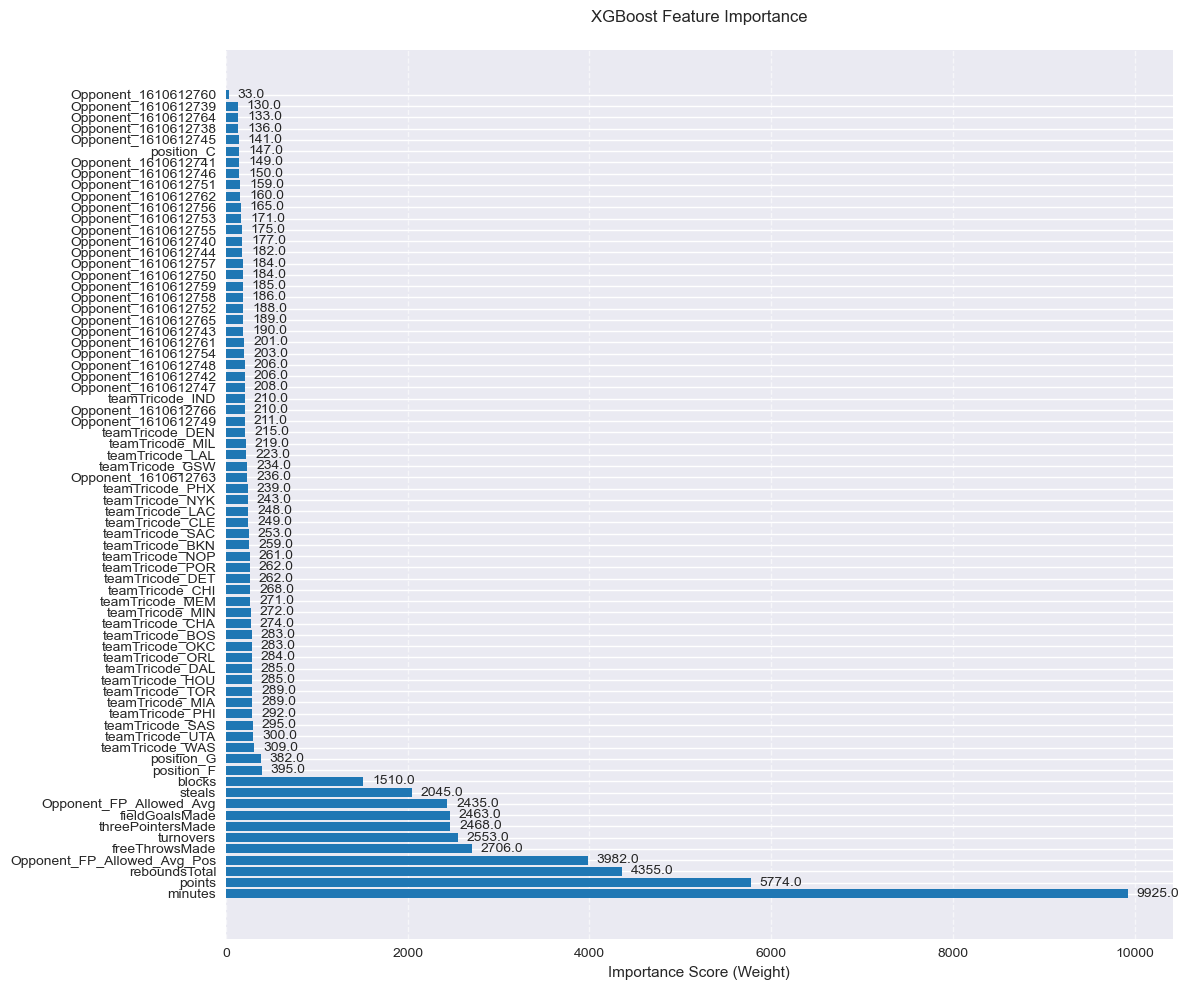

In [38]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np

# Set style for better visualization
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [12, 8]

# Features to exclude (keep only relevant predictors)
exclude = ['FP', 'game_id', 'game_date', 'personId', 'name', 'teamId', 'comment']
features = [col for col in boxscore_df_transformed.columns if col not in exclude]

# Time-based split
X_train, y_train = train[features], train['FP']
X_test, y_test = test[features], test['FP']

# Train XGBoost with temporal cross-validation
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'mae',
    'max_depth': 6,
    'eta': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'early_stopping_rounds': 50,
    'seed': 42  # for reproducibility
}

model = xgb.train(
    params, 
    dtrain, 
    num_boost_round=1000,
    evals=[(dtrain, 'train'), (dtest, 'test')],
    verbose_eval=20
)

# ================= IMPROVED FEATURE IMPORTANCE PLOT =================
# Get feature importance data
importance = model.get_score(importance_type='weight')  # or 'gain', 'cover'

# Sort features by importance
sorted_idx = np.argsort(list(importance.values()))
sorted_features = np.array(list(importance.keys()))[sorted_idx]
sorted_values = np.array(list(importance.values()))[sorted_idx]

# Create custom plot
fig, ax = plt.subplots(figsize=(12, 10))
y_pos = np.arange(len(sorted_features))

# Use horizontal bars for better readability
bars = ax.barh(y_pos, sorted_values, align='center', color='#1f77b4')
ax.set_yticks(y_pos)
ax.set_yticklabels(sorted_features)
ax.invert_yaxis()  # Most important on top
ax.set_xlabel('Importance Score (Weight)')
ax.set_title('XGBoost Feature Importance', pad=20)

# Add value labels to bars
for bar in bars:
    width = bar.get_width()
    ax.text(width + max(sorted_values)*0.01, 
            bar.get_y() + bar.get_height()/2,
            f'{width:.1f}',
            va='center')

# Improve feature name readability
ax.tick_params(axis='y', labelsize=10)
plt.tight_layout()

# Add grid for better readability
ax.grid(True, axis='x', linestyle='--', alpha=0.6)

plt.show()

In [116]:
X_train, X_test , y_train, y_test = train_test_split(boxscore_df_transformed.drop(['FP', 'game_date'], axis=1),
                                                     boxscore_df_transformed['FP'], test_size=.15, random_state=10)
# Calculate weights based on dates (using the original dataframe)
train_indices = X_train.index
dates_train = boxscore_df_transformed.loc[train_indices, 'game_date']
days_since = (dates_train - dates_train.min()).dt.days
sample_weights = np.exp(days_since / days_since.max())


LRmodel = LinearRegression(fit_intercept=True)
# Fit the model with sample weights
LRmodel.fit(X_train, y_train,sample_weight=sample_weights)

LinearRegression()

In [117]:
y_pred = LRmodel.predict(X_test)
r2_score(y_test, y_pred)

0.9311510887334358

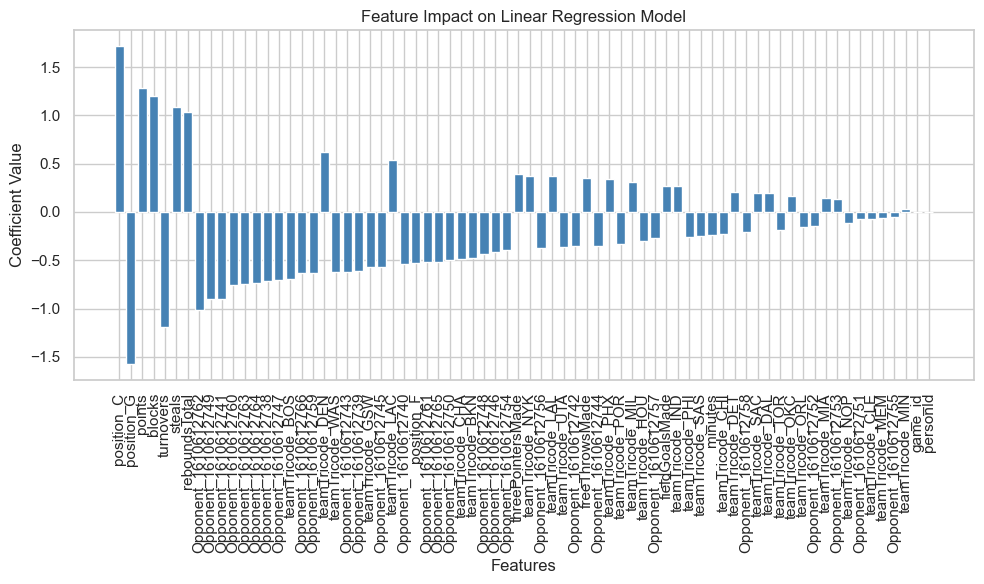

In [120]:
features = X_train.columns
coefficients = LRmodel.coef_
# Sort features by the absolute coefficient values
abs_coefficients = np.abs(coefficients)
sorted_idx = np.argsort(abs_coefficients)[::-1]
sorted_features = features[sorted_idx]
sorted_coefficients = coefficients[sorted_idx]

plt.figure(figsize=(10, 6))
plt.bar(range(len(sorted_features)), sorted_coefficients, color='steelblue')
plt.xticks(range(len(sorted_features)), sorted_features, rotation=90)
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.title('Feature Impact on Linear Regression Model')
plt.tight_layout()
plt.show()

#### Second Model : K-Nearest Neighbors (KNN) Regressor Model

In [124]:
# Import necessary libraries for model training
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor

model = KNeighborsRegressor()

test_sizes = [0.15, 0.2, 0.25, 0.3]
random_states = [0, 1, 42, 43, 100, 313]


best_test_size = None
best_random_state = None
best_r2_score = -float('inf')


# First, prepare the feature matrix by dropping both 'FP' and 'game_date'
X = boxscore_df_transformed.drop(['FP', 'game_date'], axis=1)
y = boxscore_df_transformed['FP']

for test_size in test_sizes:
    for random_state in random_states:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
        
        # Calculate weights based on dates (using the original dataframe)
        train_indices = X_train.index
        dates_train = boxscore_df_transformed.loc[train_indices, 'game_date']
        days_since = (dates_train - dates_train.min()).dt.days
        sample_weights = np.exp(days_since / days_since.max())
        
        # Fit the model with sample weights
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        r2 = r2_score(y_test, y_pred)
        
        if r2 > best_r2_score:
            best_r2_score = r2
            best_test_size = test_size
            best_random_state = random_state

# Print the best parameters and score
print(f"Best test size: {best_test_size}")
print(f"Best random state: {best_random_state}")
print(f"Best R2 score: {best_r2_score:.4f}")

Best test size: 0.15
Best random state: 100
Best R2 score: 0.5940


### Random Forest Regressor

In [ ]:
test_sizes = [0.1, 0.15, 0.2, 0.3]
random_states = [0, 1, 42, 43, 100, 313]

best_test_size = None
best_random_state = None
best_r2_score = -float('inf')



FP                     1.00
minutes                0.65
freeThrowsMade         0.62
reboundsTotal          0.59
threePointersMade      0.56
                       ... 
teamTricode_CHA       -0.02
teamTricode_WAS       -0.03
Opponent_1610612760   -0.03
teamTricode_ORL       -0.03
personId              -0.10
Name: FP, Length: 72, dtype: float64
Random Forest R² Score: 0.7603


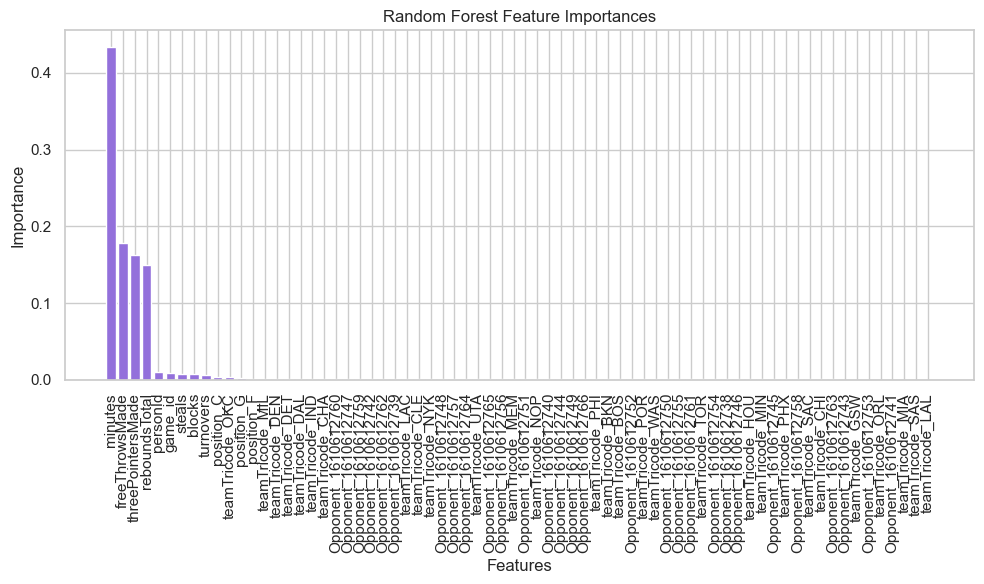

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import numpy as np
import matplotlib.pyplot as plt

# Prepare feature matrix and target variable
X = boxscore_df_transformed.drop(['FP','game_date'], axis=1)
y = boxscore_df_transformed['FP']

# Split the data (using parameters similar to your LR and KNN models)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=10)

# Calculate sample weights based on game_date for the training set
train_indices = X_train.index
dates_train = boxscore_df_transformed.loc[train_indices, 'game_date']
days_since = (dates_train - dates_train.min()).dt.days
sample_weights = np.exp(days_since / days_since.max())

# Initialize and train the Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=10)
rf_model.fit(X_train, y_train, sample_weight=sample_weights)

# Predict and compute R² score on the test set
y_pred_rf = rf_model.predict(X_test)
r2_rf = r2_score(y_test, y_pred_rf)
print(f"Random Forest R² Score: {r2_rf:.4f}")

# Plot feature importances from the Random Forest model
features = X_train.columns
importances = rf_model.feature_importances_
sorted_idx = np.argsort(importances)[::-1]
sorted_features = features[sorted_idx]
sorted_importances = importances[sorted_idx]

plt.figure(figsize=(10,6))
plt.bar(range(len(sorted_features)), sorted_importances, color='mediumpurple')
plt.xticks(range(len(sorted_features)), sorted_features, rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Random Forest Feature Importances")
plt.tight_layout()
plt.show()